# Topic Modelling


In [ ]:
pip install gensim

In [ ]:
!pip install --upgrade gensim

In [ ]:
pip install pyLDAvis

In [ ]:
pip install --upgrade pip

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [ ]:
pip install --upgrade jupyter notebook

In [ ]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.nmf import Nmf as GensimNmf


# spacy for lemmatization
import spacy


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Prepare StopWords

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Import Newsgroups Data

In [ ]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


## Remove emails and newline characters
As you can see there are many emails, newline and extra spaces that is quite distracting. Let’s get rid of them using regular expressions

In [ ]:
# Convert to list
data = df.content.values.tolist()
pprint(data[:1])

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[0:1])

["From: lerxst@wam.umd.edu (where's my thing)\n"
 'Subject: WHAT car is this!?\n'
 'Nntp-Posting-Host: rac3.wam.umd.edu\n'
 'Organization: University of Maryland, College Park\n'
 'Lines: 15\n'
 '\n'
 ' I was wondering if anyone out there could enlighten me on this car I saw\n'
 'the other day. It was a 2-door sports car, looked to be from the late 60s/\n'
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition,\n'
 'the front bumper was separate from the rest of the body. This is \n'
 'all I know. If anyone can tellme a model name, engine specs, years\n'
 'of production, where this car is made, history, or whatever info you\n'
 'have on this funky looking car, please e-mail.\n'
 '\n'
 'Thanks,\n'
 '- IL\n'
 '   ---- brought to you by your neighborhood Lerxst ----\n'
 '\n'
 '\n'
 '\n'
 '\n']
['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wond

## Tokenize words and Clean-up text
We need to break down each sentence into a list of words through tokenization, while clearing up all the messy text in the process

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


## Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring. Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


## Remove Stopwords, Make Bigrams and Lemmatize
The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

## Let’s call the functions in order

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


## Create the Dictionary and Corpus needed for Topic Modeling

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized 

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts] #corpus is a stream of input documents = training examples:
                                                   #bow -->bag-of-words format -> mapping of (word_id, word_frequency).
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]]


As we can see above: For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on. This is used as the input by the LDA model

## Building the Topic Model

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.049*"year" + 0.023*"last" + 0.023*"team" + 0.021*"game" + 0.021*"first" + '
  '0.017*"go" + 0.016*"next" + 0.016*"play" + 0.015*"win" + 0.014*"start"'),
 (1,
  '0.076*"church" + 0.053*"cpu" + 0.041*"turkish" + 0.036*"son" + '
  '0.032*"armenian" + 0.027*"upgrade" + 0.021*"inhabitant" + 0.019*"escape" + '
  '0.019*"soul" + 0.018*"proceed"'),
 (2,
  '0.262*"ax" + 0.222*"max" + 0.075*"character" + 0.037*"font" + '
  '0.020*"trivial" + 0.012*"plot" + 0.012*"click" + 0.004*"rushdie" + '
  '0.004*"precedent" + 0.001*"islamic_law"'),
 (3,
  '0.124*"law" + 0.048*"israeli" + 0.036*"format" + 0.036*"jewish" + '
  '0.032*"state" + 0.030*"citizen" + 0.030*"willing" + 0.022*"waste" + '
  '0.019*"party" + 0.019*"homosexual"'),
 (4,
  '0.041*"patient" + 0.029*"body" + 0.024*"police" + 0.023*"eat" + '
  '0.021*"safety" + 0.021*"route" + 0.020*"cool" + 0.019*"treatment" + '
  '0.019*"meet" + 0.019*"disease"'),
 (5,
  '0.022*"may" + 0.017*"make" + 0.014*"people" + 0.013*"also" + 0.012*"many" +

### How to interpret this?
Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

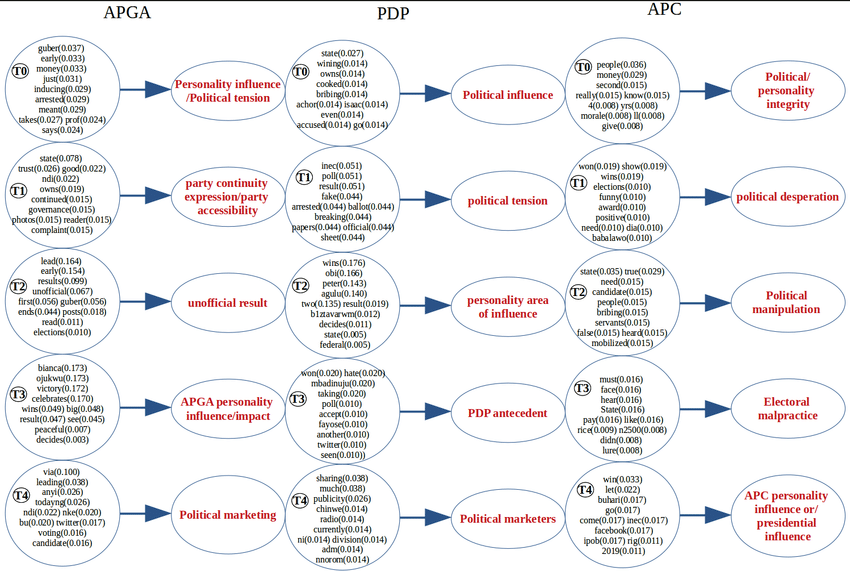

## Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.89426769844373


## Using NMF

In [ ]:
nmf = GensimNmf(
    corpus=corpus,
    num_topics=20,
    id2word=id2word,
    chunksize=100,
    passes=10,
    eval_every=10,
    minimum_probability=0,
    random_state=100,
    kappa=1,
)

In [ ]:
# Print the Keyword in the 10 topics
pprint(nmf.print_topics())
doc_nmf = nmf[corpus]

[(0,
  '0.024*"gun" + 0.014*"law" + 0.012*"firearm" + 0.010*"state" + 0.010*"right" '
  '+ 0.009*"file" + 0.009*"article" + 0.008*"crime" + 0.007*"report" + '
  '0.007*"issue"'),
 (1,
  '0.015*"may" + 0.014*"entry" + 0.012*"atheist" + 0.009*"many" + 0.009*"must" '
  '+ 0.009*"make" + 0.009*"believe" + 0.008*"exist" + 0.007*"religion" + '
  '0.006*"question"'),
 (2,
  '0.051*"write" + 0.047*"line" + 0.026*"article" + 0.014*"output" + '
  '0.011*"read" + 0.009*"open" + 0.009*"program" + 0.009*"host" + '
  '0.008*"return" + 0.007*"name"'),
 (3,
  '0.036*"drive" + 0.017*"system" + 0.014*"scsi" + 0.013*"use" + '
  '0.012*"problem" + 0.012*"bit" + 0.010*"window" + 0.010*"driver" + '
  '0.010*"support" + 0.009*"run"'),
 (4,
  '0.102*"would" + 0.012*"could" + 0.012*"think" + 0.009*"good" + 0.008*"be" + '
  '0.008*"make" + 0.007*"time" + 0.007*"know" + 0.006*"really" + 0.006*"seem"'),
 (5,
  '0.022*"come" + 0.019*"go" + 0.015*"take" + 0.014*"could" + 0.013*"see" + '
  '0.013*"know" + 0.011*"apa

In [ ]:
# Compute Coherence Score
coherence_model_nmf = CoherenceModel(model=nmf, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_nmf = coherence_model_nmf.get_coherence()
print('\nCoherence Score: ', coherence_nmf)


Coherence Score:  0.5517586888246168
